# Causal Data Science Week 4 Tutorial

In this tutorial, we will cover two additional methods for identifying estimands from a causal graph: frontdoor criterion and instrumental variables. We will also show how to calculate causal estimates based on these estimands.

### Frontdoor Criterion

The frontdoor criterion is similar to the backdoor criterion, only now we move along 'forward' paths rather than 'backwards' paths. The below definition and example are from: https://medium.data4sci.com/causal-inference-part-xii-front-door-criterion-38bec5172f3e.

A set of variables **Z** is said to satisfy the front-door criterion relative to an ordered pair of variables ($X_i$, $X_j$), if:
1. **Z** intercepts all directed paths from $X_i$ to $X_j$
2. There is no unblocked backdoor path from $X_i$ to **Z**
3. All backdoor paths from **Z** to $X_j$ are blocked by $X_i$

Let's consider the same graph as in week 3 and identify possible frontdoor criterion adjustment sets for the effect of $X$ on $Y$.

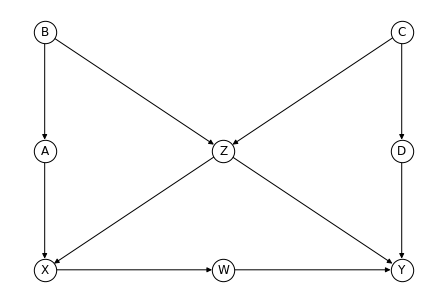

In [1]:
# we import networkx and create a directed graph
import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(['A', 'B', 'C', 'D', 'W', 'X', 'Y', 'Z'])

G.add_edges_from([('B','A'), ('B','Z'), ('C','Z'), ('C','D'), 
                  ('A','X'), ('Z','X'), ('Z','Y'), ('D','Y'),
                 ('X','W'), ('W','Y')])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear) 
# and save it to a .gml format (for using DoWhy later)
pos = {'B': (-1, 1),              'C': (1, 1),
         'A': (-1, 0), 'Z': (0, 0), 'D': (1, 0),
         'X': (-1, -1), 'W': (0, -1), 'Y': (1, -1),}
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors ='black')
nx.write_gml(G, "frontdoor_criterion_graph.gml")

In this tutorial, we will create a DoWhy CausalGraph object, which has many functions built-in that calculate what we did manually in the previous tutorial.

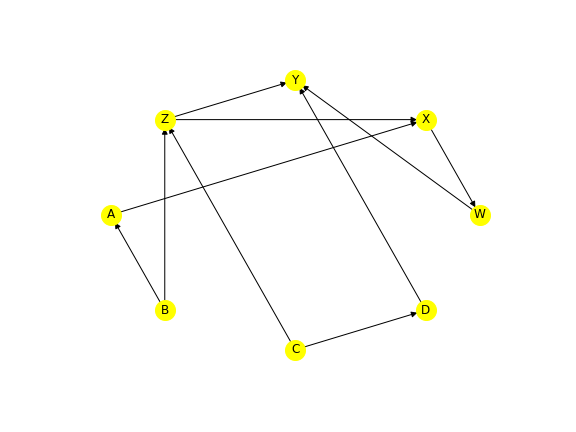

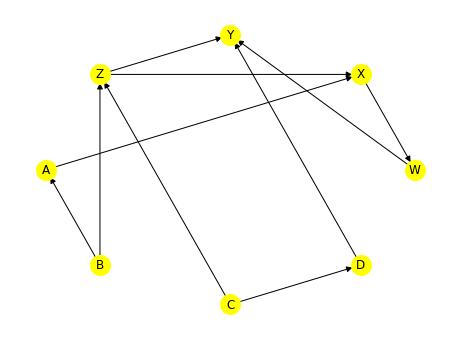

In [2]:
import dowhy
import pandas as pd
from dowhy import CausalModel

# once again we use arbitrary data, since we are still focused on the graph and not data
df = pd.DataFrame({'A':[1],'B':[1],'C':[1],'D':[1],'W':[1],'X':[1],
                  'Y': [1], 'Z': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('frontdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment='X',
        outcome='Y',
        graph=gml_graph
        )
model.view_model()

display(Image(filename="causal_model.png", width = 200, height = 100))

In [3]:
# we extract the CausalGraph object from our CausalModel object
our_causal_graph = model._graph

Now we can find an adjustment set that satisfies the frontdoor criterion. We first need all directed paths from $X$ to $Y$, as our adjustment set needs to intercept all such paths.

In [4]:
# function for finding all directed paths between the two nodes given
our_causal_graph.get_all_directed_paths('X', 'Y')

[['X', 'W', 'Y']]

There is only one such directed path, and this path only contains the extra node $W$. So our only possible adjustment set is {$W$}. We now need to check whether this set satisfies the other requirements in the criterion.

We first find all backdoor paths from $X$ to $W$.

In [5]:
# function that finds backdoor paths from the first node to the second
x_w_backdoor_paths = our_causal_graph.get_backdoor_paths('X', 'W')
x_w_backdoor_paths # These paths must all be blocked.

[['X', 'A', 'B', 'Z', 'C', 'D', 'Y', 'W'],
 ['X', 'A', 'B', 'Z', 'Y', 'W'],
 ['X', 'Z', 'C', 'D', 'Y', 'W'],
 ['X', 'Z', 'Y', 'W']]

For each of these paths, we need to confirm that they are blocked. As the adjustment set we are consider is only the node $W$, this blocking needs to be not conditioned on any other nodes (i.e. there needs to be a collider on each of these paths).

In [6]:
# list for keeping track of which paths are blocked
path_is_blocked = []

# looping through the backdoor paths from X to W
for path in x_w_backdoor_paths:
    # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
    # in this case, we are not conditioning on any nodes, so give it the empty set
    path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = [])) # not condition on anything in this case

path_is_blocked

[True, True, True, True]

We see that all of the paths are blocked. Looking at the graph, this is because the node $Y$ is a collider on each of the paths, and we are not conditioning on $Y$.

Finally, we need to check that all backdoor paths from $W$ to $Y$ are blocked by $X$.

In [7]:
w_y_backdoor_paths = our_causal_graph.get_backdoor_paths('W', 'Y')
w_y_backdoor_paths

[['W', 'X', 'A', 'B', 'Z', 'C', 'D', 'Y'],
 ['W', 'X', 'A', 'B', 'Z', 'Y'],
 ['W', 'X', 'Z', 'C', 'D', 'Y'],
 ['W', 'X', 'Z', 'Y']]

For each of the above paths, we need to check whether they are blocked by $X$. We can do so in the same way as above.

In [8]:
# list for keeping track of which paths are blocked
path_is_blocked = []

# looping through the backdoor paths from W to Y
for path in w_y_backdoor_paths:
    # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
    # in this case, we are conditioning on the set [X]
    path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = ['X']))

path_is_blocked

[True, True, True, True]

We can see that all paths are blocked by $X$. Thus, the set {$W$} meets the frontdoor criterion and is a valid adjustment set for measuring the effect of $X$ on $Y$.

As always, the process is completed by DoWhy in the background. We can see under Estimand 3 that it has correctly identified {$W$} as an adjustment set.

In [9]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                      
────(Expectation(Y|Z,B))
d[X]                    
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,B,U) = P(Y|X,Z,B)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(Y, [W])*Derivative([W], [X]))
Estimand assumption 1, Full-mediation: W intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{W} then P(W|X,U) = P(W|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{W} and U→Y then P(Y|W, X, U) = P(Y|W, X)



Most of the functions we have applied here are from the DoWhy CausalGraph object (https://github.com/microsoft/dowhy/blob/master/dowhy/causal_graph.py)

### Instrumental variables

Instrumental variables can be used when you have unobserved confounders, limiting your ability to apply backdoor or frontdoor criterion. In order for a variable $Z$ to qualify as an instrumental variable for measuring the effect of $X$ on $Y$, it needs to meet the following conditions<sup>[1]</sup>:
1. $Z$ has a causal effect on $X$
2. $Z$ affects the outcome $Y$ only through $X$
3. $Z$ and $Y$ have no common causes

[1] Instruments for Causal Inference (Hernan and Robins, 2006)

We will look at the example given by DoWhy at https://microsoft.github.io/dowhy/example_notebooks/dowhy-simple-iv-example.html.

In this example, we want to estimate the effect of education on income. We assume there is a confounder, called 'ability', that impacts on both education and income, but we cannot observe this variable. Furthermore, we assume that there is an education voucher that affects education, but has no direct effect on income and is not affected by 'ability'.

We create the graph showing this, where $U$ represents the unobservable, confounding 'ability'.

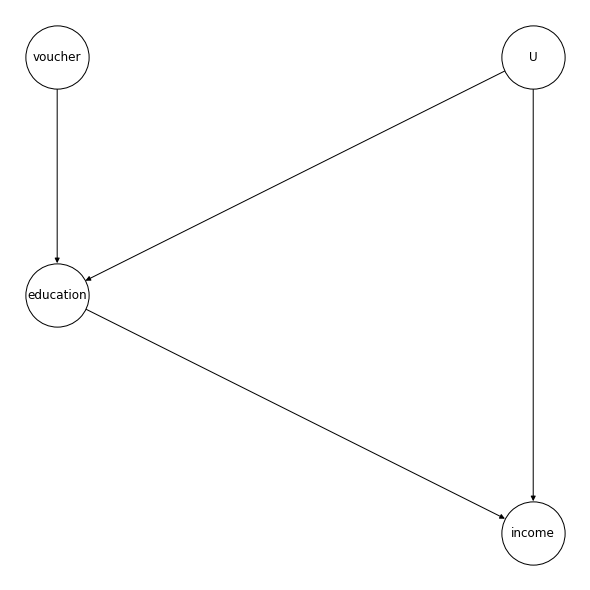

In [10]:
G = nx.DiGraph()

G.add_nodes_from(['voucher', 'education', 'U', 'income'])
G.add_edges_from([('voucher','education'), ('education','income'), ('U','education'),
                 ('U','income')])
nx.write_gml(G, "instrumental_variables_graph.gml")

# plotting with a slightly bigger plot and nodes placed in good positions
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
pos = {'voucher': (1,2), 'education': (1,1), 'U': (2,2), 'income': (2,0)}
nx.draw(G, pos= pos, with_labels=True, node_size=4000, node_color='w', edgecolors ='black')

# We have no way of controlling u. Tehrefore, we make voucher out intrumental variable. 

If we were able to observe $U$, we could apply the backdoor criterion and condition on it. But, since we are assuming $U$ is unobservable, we instead need to use the 'voucher' variable.

We can check if 'voucher' meets the conditions for an instrumental variable:
1. It has a direct causal effect on 'education'
2. There is no direct effect of 'voucher' on 'income'
3. 'voucher' and 'income' share no common causes

As it meets all conditions, we can use 'voucher' as an instrumental variable.


As before, we can also identify this variable using DoWhy. In this case, we simply do not provide values for $U$ to the CausalModel, which tells it that the variable is unobserved.

We start by simulating data for ability, voucher, education, and income. These data are not critical to understanding the application of instrumental variables, as we are currently more interested in the graph.

In [11]:
import numpy as np
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4

# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

# build dataset (exclude confounder `ability` which we assume to be unobserved)
data = np.stack([education, income, voucher]).T # We do not include ability. Only give the variables we are able to measure. But we give the full graph. 
df = pd.DataFrame(data, columns = ['education', 'income', 'voucher'])

As before, we provide our graph, treatment and outcome variables, and the data to DoWhy.

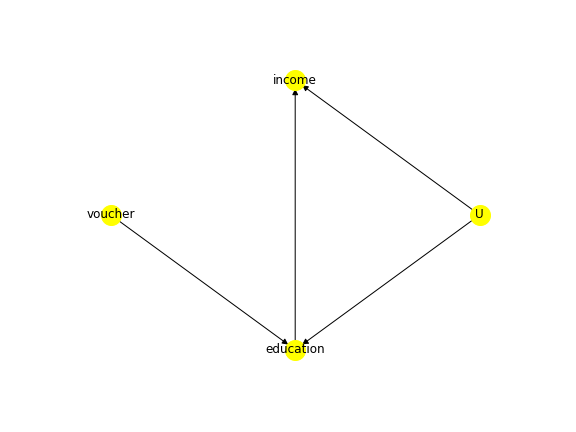

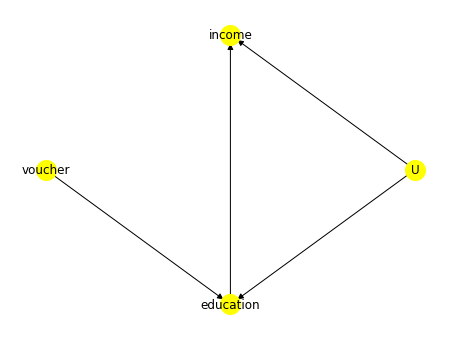

In [12]:
# we create and display the causal graph we are assuming
gml_graph = gml_to_string('instrumental_variables_graph.gml')
model=CausalModel(
        data = df,
        treatment='education',
        outcome='income',
        graph=gml_graph
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

By not providing $U$ values, DoWhy recognises that the backdoor criterion cannot be used since we can no longer condition on $U$. However, it correctly identifies that we can use 'voucher' as an instrumental variable in Estimand 2.

In [13]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(income, [voucher])*Derivative([education], [voucher])**
(-1))
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Worth noting: there are also possible conditional instrumental variables in certain causal graphs. DoWhy is not able to identify these correctly, so be warned!

### Estimating Causal Effects

Now that we have seen how to identify valid adjustment sets, we wish to apply them to estimate a causal effect from our data. We choose which statistical methods to apply to estimate the effect based on our adjustment set.

Let's look at an example using simulated linear data from DoWhy (https://microsoft.github.io/dowhy/example_notebooks/dowhy_simple_example.html). The true causal effect is beta = 10.

In [14]:
import dowhy.datasets

# we generate linear data with beta = 10 being the true causal effect (this is the value we wish to estimate from the data)
num_samples = 20000
data = dowhy.datasets.linear_dataset(beta=10, # True linear causal effect is 10. 
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=0,
        num_samples=num_samples,
        treatment_is_binary=True,
        num_discrete_common_causes=1)
df = data["df"]

In [15]:
# v0 is our (binary) treatment variable, and y is our outcome variable
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.971049,1.089133,1.596977,0.025203,1.306919,1,True,28.242678
1,0.0,0.534948,0.357381,1.252651,-0.686804,-0.912986,1,True,11.996046
2,1.0,0.646910,-0.443039,0.819074,-0.948329,-2.373068,0,True,-0.867379
3,1.0,0.228472,0.671259,0.616258,2.389023,-0.663844,0,True,17.199946
4,0.0,0.799932,1.836327,2.322831,0.636119,0.239441,1,True,29.837841
...,...,...,...,...,...,...,...,...,...
19995,0.0,0.855679,1.591774,0.545626,0.442139,0.843687,0,True,21.564067
19996,0.0,0.018396,-0.323854,0.205786,-0.140985,-0.640044,2,False,-1.382206
19997,0.0,0.704109,1.178837,3.020688,0.082839,0.664609,2,True,33.768259
19998,1.0,0.106024,-0.215936,2.580372,-1.391058,0.229971,0,True,20.914138


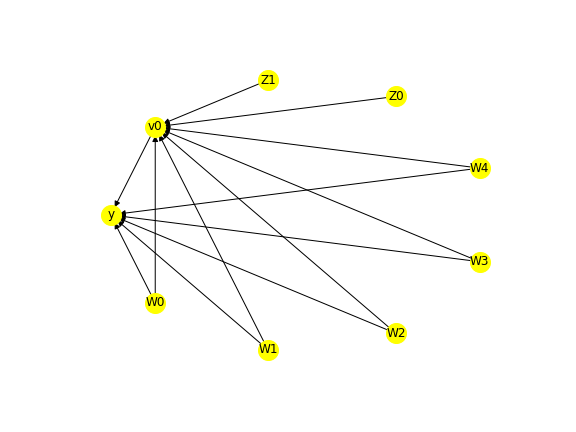

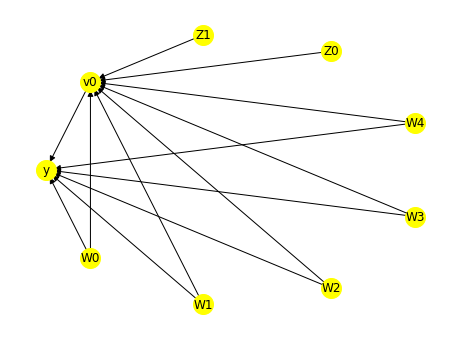

In [16]:
# we use the data and the graph it is generated from to create a CausalModel object
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

model.view_model()
display(Image(filename="causal_model.png"))

We will not manually apply the backdoor criterion, frontdoor criterion, or instrumental variables; instead, we will simply use the valid adjustment sets found by DoWhy. We see that there are no sets satisfying the frontdoor criterion, but there are for the backdoor and instrumental variables. You can check yourself that these satisfy the criteria.

In [17]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand) #Z0 and Z1

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W2,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W2,W3,U) = P(y|v0,W0,W4,W1,W2,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Let's use the set identified by the backdoor criterion. We can thus estimate the effect of v0 on y when we condition on W0, W1, W2, W3, and W4.

Let's first try estimate the effect without conditioning on these extra variables. Suppose we expect (know) that the effect is linear. We can then apply a linear estimator to find the effect. We will use linear regression.

In [18]:
# we first use only v0 and y
# we need to reshape them into the correct shape for our linear regression function
v0_vals = df['v0'].values.reshape(num_samples, 1)
y_vals = df['y'].values.reshape(num_samples, 1)

In [19]:
# we import the LinearRegression object from sklearn
from sklearn.linear_model import LinearRegression

# we fit a linear regression model with v0 and y, and check what the estimated linear effect is
linear_regressor = LinearRegression() 
linear_regressor.fit(v0_vals, y_vals)
linear_regressor.coef_

array([[20.96208797]])

We see that the estimated linear effect is highly biased, but we expected this knowing we needed to condition on the correct sets. Let's try conditioning on only part of a valid adjustment set.

In [20]:
# we first collect the extra variables we wish to include
W0_vals = df['W0'].values.reshape(num_samples, 1)
W1_vals = df['W1'].values.reshape(num_samples, 1)

# we need to combine all of the variables we're including into one array
v0_W0_W1_vals = np.concatenate((v0_vals, W0_vals, W1_vals), axis = 1)
v0_W0_W1_vals

array([[ 1.        ,  1.08913295,  1.59697717],
       [ 1.        ,  0.35738051,  1.25265054],
       [ 1.        , -0.44303851,  0.81907445],
       ...,
       [ 1.        ,  1.17883679,  3.02068792],
       [ 1.        , -0.21593639,  2.58037164],
       [ 1.        ,  0.73951322,  1.78331714]])

In [21]:
# we fit the linear regression with the extra variables included
linear_regressor.fit(v0_W0_W1_vals, y_vals)
linear_regressor.coef_

array([[12.3362611 ,  2.01227359,  5.17490758]])

We see that our estimate (the first coeffcient) is still biased. Now, we try using the correct conditioning set.

In [22]:
W2_vals = df['W2'].values.reshape(num_samples, 1)
W3_vals = df['W3'].values.reshape(num_samples, 1)
# W4 is a categorical value, so we use the pandas' get_dummy function to turn it into dummy variables
W4_vals = pd.get_dummies(df['W4'].values).iloc[:,1:4]

backdoor_vars = np.concatenate((v0_vals, W0_vals, W1_vals, W2_vals, W3_vals, W4_vals), axis = 1)
backdoor_vars

array([[ 1.        ,  1.08913295,  1.59697717, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.35738051,  1.25265054, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        , -0.44303851,  0.81907445, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        ,  1.17883679,  3.02068792, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        , -0.21593639,  2.58037164, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.73951322,  1.78331714, ...,  0.        ,
         1.        ,  0.        ]])

In [23]:
linear_regressor.fit(backdoor_vars, y_vals)
linear_regressor.coef_ # 10.00048064 <- We see that the value is pretty close to the real 10. 

array([[10.00048064,  2.12576632,  5.27927954,  2.45344285,  5.02274398,
         0.88970752,  1.77936808,  2.66912173]])

Now our estimate (the first coefficient) is unbiased. So we would thus correctly conclude that our linear causal effect is 10.

DoWhy allows you to estimate causal effects using different estimators based on the adjustment sets it identifies. We can do what we did above by calling the estimate_effect function on our identified_estimand and specifying which criterion we wish to use, and which estimator. The different estimators you can use are available here: https://github.com/microsoft/dowhy/tree/master/dowhy/causal_estimators. When calling the estimator, exclude the '_estimator' at the end.

Below, we specify we want to use the adjustment set from the backdoor criterion and a linear regression estimator.

In [24]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W2,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W2,W3,U) = P(y|v0,W0,W4,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W4+W1+W2+W3
Target units: ate

## Estimate
Mean value: 10.000480644994171

Causal Estimate is 10.000480644994171


We see that we get the same estimate as when we performed the procedure manually. Let's try one other backdoor estimator and an instrumental variable estimator.

In [25]:
# using the backdoor adjustment set and propensity score stratification
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W2,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W2,W3,U) = P(y|v0,W0,W4,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W4+W1+W2+W3
Target units: ate

## Estimate
Mean value: 12.741383165962846

Causal Estimate is 12.741383165962846


In [26]:
# using the instrumental variables
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable") # iv.linear_regression
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                       0.773
Model:                         IV2SLS   Adj. R-squared:                  0.773
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Mon, 28 Feb 2022                                         
Time:                        13:26:24                                         
No. Observations:               20000                                         
Df Residuals:                   19999                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v0            14.4596      0.064    225.106      0.0

Not every estimator will always give a good estimate. This depends on the true nature of the effect (linear, exponential, etc.), and the assumptions made by the estimator. We can do this one correctly using the IV notebook shown by Sara in class which implements 2SLS.

In [27]:
# we define a function to extract our linear regression coefficient
def linear_coeff(X,Y):
    linear_regressor = LinearRegression() 
    linear_regressor.fit(X, Y)
    return linear_regressor.coef_

In [28]:
# we reshape the variables we are going to use (Z1 is a sufficient instrumental variable)
v0 = df['v0'].values.reshape(-1,1)
z1 = df['Z1'].values.reshape(-1,1)
y = df['y'].values.reshape(-1,1)

In [29]:
# we can calculate the linear effect that Z1 has on v0, and what our estimated linear v0 values are
vhat = linear_coeff(z1, v0) * z1

In [30]:
# we can finally calculate the linear effect of vhat on y
linear_coeff(vhat, y)

array([[11.57412835]])